##Install Library

Di sini kami menginstall beberapa library eksternal. Library eksternal yang kami gunakan adalah:
- **`Sastrawi`** untuk proses ***stemming*** dan **penghapusan kata hubung**
- **`fasttext`** untuk proses **word embedding**

In [ ]:
!pip install Sastrawi
!pip install fasttext

##Import Library

Di sini kami menggunakan beberapa library untuk berbagai keperluan.
- Untuk kebutuhan **manipulasi data** kami menggunakan **`pandas`** dan **`numpy`**. Sedangkan untuk kebutuhan **utilitas**, kami menggunakan library **`IPython`**
- Untuk kebutuhan **visualisasi**, kami menggunakan **`matplotlib`** dan **`wordcloud`**
- Untuk **membersihkan data teks**, kami menggunakan library dari **`Sastrawi`**
- Untuk kebutuhan pada saat pembuatan model, kami menggunakan library **`fasttext`** untuk proses ***word embedding***, **`imblearn`** untuk menangani **ketidakseimbangan sample**, **`sklearn`** dan **`keras`** dalam proses pembuatan **arsitektur model**

In [ ]:
# DATA
import pandas as pd
import numpy as np

# Utility
import itertools
from IPython.display import clear_output

# VISUALIZATION
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# PREPROCESSING
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# CREATING MODEL
import fasttext as ft
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

##Load Data

Dataset yang kami gunakan adalah dataset hasil ***scraping*** dari platform freelance [projects.co.id](https://projects.co.id/) dengan kategori layanan **web development** yang telah dilakukan proses **klasterisasi** untuk menentukan labelnya.

In [ ]:
data_path = "https://gist.githubusercontent.com/pijarpahlawan/31bbc3a1dcf6ceb2fa6a9de745071929/raw/46398f419f874c5b8528e36936af1685f71420da/labeled_website_development_services_data.csv"
df = pd.read_csv(data_path, header=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218 entries, 0 to 3217
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Nama Layanan              3218 non-null   object
 1   Rating Layanan (n/10)     3218 non-null   int64 
 2   Jumlah Penjualan Layanan  3218 non-null   int64 
 3   Harga Layanan (Rp)        3218 non-null   int64 
 4   Durasi Pengerjaan (hari)  3218 non-null   int64 
 5   Nama Penjual              3218 non-null   object
 6   Rating Penjual (n/10)     3218 non-null   int64 
 7   Jumlah Penjualan Penjual  3218 non-null   int64 
 8   Deskripsi Layanan         3218 non-null   object
 9   Label                     3218 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 251.5+ KB


In [ ]:
df.sample(10)

,Nama Layanan,Rating Layanan (n/10),Jumlah Penjualan Layanan,Harga Layanan (Rp),Durasi Pengerjaan (hari),Nama Penjual,Rating Penjual (n/10),Jumlah Penjualan Penjual,Deskripsi Layanan,Label
2999,jasa pembuatan website e-learning,0,0,5000000,7,ramdan3mts,0,0,website e-learning (moodle) untuk diimplementa...,0
2989,jasa pembuatan website + hosting 1 tahun,0,0,1000000,10,wajit007,0,0,"hai teman-teman, saya adalah mahasiswa bisnis ...",0
2622,"pembuatan website, dxp ahlinya!!",0,0,2000000,21,icaldxp,0,0,website development we believe in close coll...,0
1185,jasa konsultasi perancangan sistem berbasis web,0,0,125000,10,salsabillahdk,0,0,jika anda memiliki tugas atau ingin membuat se...,0
159,management dental/gigi ( web based ),0,0,3000000,1,boygunawan12,10,27,"bagi anda yang punya klinik gigi, pastinya per...",0
3097,jasa pembuatan website dengan framework larave...,0,0,700000,7,ahlulmukh,0,0,jasa pembuatan web admin dashboard yang terkon...,0
2220,pembuatan website profesional company profile,0,0,7000000,60,mrwwwrevi,0,0,salam ... saya menerima jasa pembuatan websit...,0
827,mempercepat load speed website wordpress di gt...,0,0,100000,2,reiznu,0,0,anda merasa website anda memiliki kecepatan lo...,0
2320,sistem spp online via sms gateaway,0,0,8500000,7,media-soft,0,0,kami menawarkan sistem informasi spp supportin...,0
254,pembuatan template website & slicing psd/fggma...,0,0,300000,7,nyomanjyotisa,0,0,anda membutuhkan template yang untuk website a...,0


##Data Preprocessing

###Cleaning data

Memeriksa kolom yang memiliki nilai null

In [ ]:
print("Kolom yang memiliki nilai null:")
df.isnull().sum()

Kolom yang memiliki nilai null:


Nama Layanan                0
Rating Layanan (n/10)       0
Jumlah Penjualan Layanan    0
Harga Layanan (Rp)          0
Durasi Pengerjaan (hari)    0
Nama Penjual                0
Rating Penjual (n/10)       0
Jumlah Penjualan Penjual    0
Deskripsi Layanan           0
Label                       0
dtype: int64

Memeriksa deskripsi statistik dari dataset

In [ ]:
df.describe()

,Rating Layanan (n/10),Jumlah Penjualan Layanan,Harga Layanan (Rp),Durasi Pengerjaan (hari),Rating Penjual (n/10),Jumlah Penjualan Penjual,Label
count,3218.000000,3218.00000,3.218000e+03,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.486638,0.18614,2.896565e+06,11.893723,1.283095,1.751088,0.053449
std,2.123622,1.49015,1.068374e+07,18.193667,3.273802,11.423348,0.240974
min,0.000000,0.00000,5.000000e+04,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,5.000000e+05,3.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,1.000000e+06,7.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,2.500000e+06,14.000000,0.000000,0.000000,0.000000
max,10.000000,41.00000,3.500000e+08,365.000000,10.000000,373.000000,2.000000


Menghapus kolom **Rating Layanan (n/10)** dan **Jumlah Penjualan Layanan** karena kedua nilai tersebut didapat setelah layanan publish. Sedangkan tujuan kita memprediksi layanan yang belum dipublish.

In [ ]:
df.drop(['Rating Layanan (n/10)', 'Jumlah Penjualan Layanan'], axis=1, inplace=True)


###Decode label

Di sini kami mengubah label dari bentuk numerikal ke bentuk kategorikal dengan pemetaan sebagai berikut:

- 0 --> LOW
- 1 --> MEDIUM
- 2 --> HIGH  

Bentuk kategorikal tersebut mencerminkan jumlah penjualan layanan

In [ ]:
decode_map = {0: "LOW", 1: "MEDIUM", 2: "HIGH"}

def decode_sales(label):
  return decode_map[int(label)]

In [ ]:
df.Label = df.Label.apply(lambda x: decode_sales(x))

Memvisualisasikan distribusi label

Text(0.5, 1.0, 'Dataset labels distribuition')

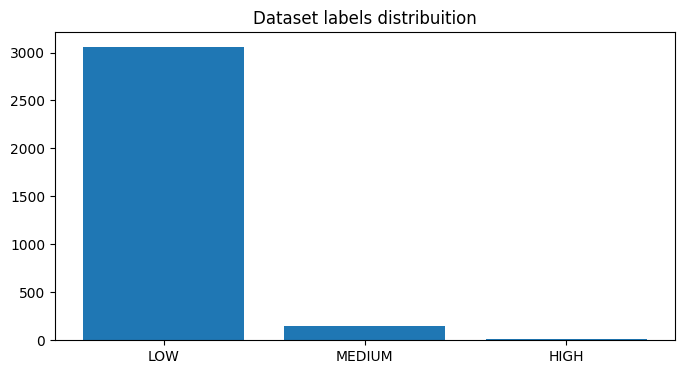

In [ ]:
label_count = df.Label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(label_count.index, label_count.values)
plt.title("Dataset labels distribuition")

Dari grafik di atas, terlihat bahwa selisih layanan berlabel **LOW** terlampau jauh bila dibandingkan dengan layanan yang berlabel **MEDIUM** dan **HIGH**

###Remove stopword and stemming

Menghapus kata hubung dan imbuhan

In [ ]:
stop_factory = StopWordRemoverFactory()
stopword = stop_factory.create_stop_word_remover()

stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

In [ ]:
def preprocess(text):
  cleaned_text = stopword.remove(text)
  stemmed_text = stemmer.stem(cleaned_text)
  return stemmed_text

In [ ]:
%%time
df['Nama Layanan'] = df['Nama Layanan'].apply(lambda x: preprocess(x))

CPU times: user 3min 43s, sys: 658 ms, total: 3min 43s
Wall time: 4min 1s


Setelah penghapusan kata hubung dan imbuhan, kami mencoba untuk memvisualisasikan kata yang sering muncul di setiap label

Text(0.5, 1.0, 'Word cloud label 0 visualization')

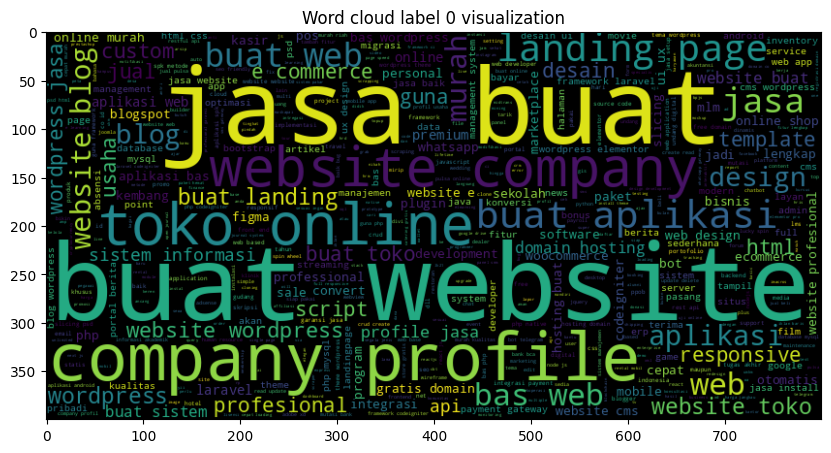

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500, width = 800, height = 400).generate(" ".join(df[df['Label'] == 'LOW']['Nama Layanan']))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud label 0 visualization')

Text(0.5, 1.0, 'Word cloud label 1 visualization')

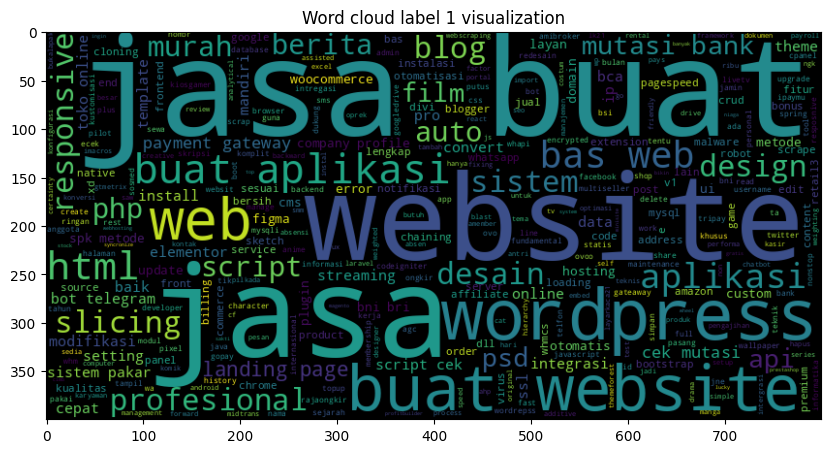

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500, width = 800, height = 400).generate(" ".join(df[df['Label'] == 'MEDIUM']['Nama Layanan']))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud label 1 visualization')

Text(0.5, 1.0, 'Word cloud label 2 visualization')

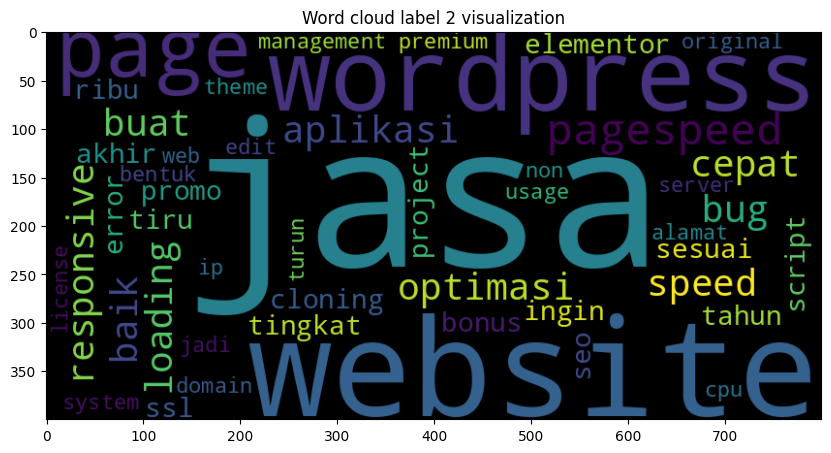

In [ ]:
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 500, width = 800, height = 400).generate(" ".join(df[df['Label'] == 'HIGH']['Nama Layanan']))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud label 2 visualization')

In [ ]:
df.sample(10)

,Nama Layanan,Harga Layanan (Rp),Durasi Pengerjaan (hari),Nama Penjual,Rating Penjual (n/10),Jumlah Penjualan Penjual,Deskripsi Layanan,Label
535,buat website nikah anniversary,3000000,30,rakhaadrida,0,0,live preview: https://ankastory.github.io ja...,LOW
1140,jasa buat aplikasi sistem pakar metode backwar...,850000,14,krotodev,10,57,aplikasi sistem pakar ini menggunakan metode b...,MEDIUM
406,jasa buat toko online online shop,1000000,10,stefanuseka,10,1,"hi, saya menyediakan jasa untuk pembuatan web...",LOW
2594,jasa buat website jannnetwork,750000,1,sjannata,0,0,jann network corporation penyedia laya...,LOW
3080,jasa buat design grapich website,500000,7,wisnuadhi00,0,0,buat tampilan website anda jadi lebih baik lag...,LOW
789,buat blog,100000,5,dwindra97,10,1,ingin desain blog anda terlihat lebih menarik ...,LOW
2825,jasa konversi figma html,250000,2,syawaluddinamin,10,2,halo yang disana! apakah anda perlu mengonve...,LOW
3173,jual script luckyspin wheel,2000000,2,aulia182,0,0,script luckyspin wheel roda putaran untuk memb...,LOW
2178,jasa buat blog bas wordpress com,100000,4,sasyaa95,0,0,apakah anda membutuhkan jasa pembuatan blog wo...,LOW
729,desain uiux website murah kualitas,150000,1,tazkiaperna,0,0,silahkan ceritakan keinginan dan tujuaan anda ...,LOW


##Model Data Preparation

###Train and Test Split

Membagi ke:
- 80% data training
- 20% data testing

In [ ]:
TRAIN_SIZE = 0.8

In [ ]:
train_data, test_data = train_test_split(df, train_size=TRAIN_SIZE, random_state=42)
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 2574
Test data size: 644


###Tokenizing and Encoding

Dalam proses tokenisasi **nama layanan**, kami mengonfigurasi vektorisasi teks untuk mengubah urutan nama layanan menjadi **representasi bilangan bula**t, memastikan bahwa setiap urutan memiliki **panjang maksimum 30**, dan **mengadaptasi** vektorisasi teks berdasarkan **data pelatihan**. Dalam proses tokenisasi ini kami mendapatkan sebanyak **1919 buah kata unik**

In [ ]:
MAX_SEQUENCE_LENGTH = 30

In [ ]:
text_vectorizer = TextVectorization(output_mode='int', output_sequence_length=MAX_SEQUENCE_LENGTH)
text_vectorizer.adapt(train_data['Nama Layanan'])
vocab_size = len(text_vectorizer.get_vocabulary())
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 1919


Kami lalu menggunakan **`text_vectorizer`** yang telah dibuat sebelumnya untuk mengonversi urutan **nama layanan** pada **data pelatihan** dan **data uji** menjadi **representasi numerik**.

In [ ]:
X_train = text_vectorizer(train_data['Nama Layanan']).numpy()
X_test = text_vectorizer(test_data['Nama Layanan']).numpy()

Di sini kami mengubah label dari bentuk **kategorikal** ke bentuk **numerikal** (seperti keadaan awalnya)

In [ ]:
encode_map = {"LOW": 0, "MEDIUM": 1, "HIGH": 2}

def encode_sales(label):
  return encode_map[label]

In [ ]:
y_train = train_data.Label.apply(lambda x: encode_sales(x))
y_test = test_data.Label.apply(lambda x: encode_sales(x))

In [ ]:
y_train.value_counts()

0    2445
1     120
2       9
Name: Label, dtype: int64

###Oversampling

Terlihat dari hasil output di atas, perbandingan jumlah data tiap datanya terpaut jauh. Maka dari itu di sini kami melakukan proses ***over-sampling*** untuk menangani ketidakseimbangan kelas pada data. Teknik *over-sampling* dengan **SMOTE** bertujuan untuk meningkatkan jumlah sampel di kelas minoritas dengan menciptakan sampel sintetis baru berdasarkan sampel yang sudah ada.

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_res.value_counts()

0    2445
1    2445
2    2445
Name: Label, dtype: int64

In [ ]:
y_train_res = pd.get_dummies(y_train_res).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

Bentuk akhir sample data yang akan digunakan.

In [ ]:
print("Training X Shape:",X_train_res.shape)
print("Testing X Shape:",X_test.shape)
print("Training y Shape:",y_train_res.shape)
print("Testing y Shape:",y_test.shape)

Training X Shape: (7335, 30)
Testing X Shape: (644, 30)
Training y Shape: (7335, 3)
Testing y Shape: (644, 3)


###Word Embedding

Berikut proses dari ***word embedding*** untuk menemukan **makna semantik** dari setiap kata dalam bahasa Indonesia menggunakan model pre-trained dari [fasttext](https://fasttext.cc/docs/en/crawl-vectors.html).

In [ ]:
EMBEDDING_DIM = 300

Pertama kita mendownload modelnya terlebih dahulu

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz

--2024-01-10 01:46:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.44, 18.165.83.91, 18.165.83.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G   135MB/s    in 42s     

2024-01-10 01:47:27 (102 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



Kemudian kita ekstrak file hasil download untuk mendapatkan file binernya

In [ ]:
%%time
!gunzip cc.id.300.bin.gz

gzip: cc.id.300.bin already exists; do you wish to overwrite (y or n)? ^C
CPU times: user 7.37 s, sys: 930 ms, total: 8.3 s
Wall time: 14min 6s


Lalu kita load model machine learning tersebut

In [ ]:
%%time
ft_model = ft.load_model('cc.id.300.bin')

CPU times: user 3.68 s, sys: 14.8 s, total: 18.5 s
Wall time: 56.6 s


Mengecek kata terdekat dari contoh kata inputan

In [ ]:
ft_model.get_nearest_neighbors('jasa')

[(0.7576980590820312, 'jasajasa'),
 (0.7230176329612732, 'Jasa'),
 (0.6863208413124084, 'jasa-'),
 (0.6699596047401428, 'jasa-jasa'),
 (0.6672199368476868, 'jasa2'),
 (0.6642885804176331, 'penyedia'),
 (0.6642025709152222, 'jasanya'),
 (0.6583756804466248, 'jasa.'),
 (0.6469535231590271, 'layanan'),
 (0.6391134262084961, 'maklon')]

Membangun ***matriks embedding*** untuk digunakan dalam pembangunan model LSTM. Matriks embedding ini dibuat dengan memasukkan vektor kata-kata dari model fasttext yang ada di vektor token dataset.

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for i, word in enumerate(text_vectorizer.get_vocabulary()):
  print(f"Progress : {format(i/vocab_size*100, '.2f')}%")
  if word in ft_model.get_words():
    embedding_matrix[i] = ft_model.get_word_vector(word)
  clear_output()
print(embedding_matrix.shape)

(1919, 300)


##Creating Model

###Build Model

Membangun model LSTM menggunakan arsitektur 4 layer sebagai berikut:
- **Embedding layer** dengan jumlah kosakata 1919 buah dan menggunakan matriks embedding yang telah dibuat sebelumnya menjadi bobotnya.
- **Dropout layer** untuk mengurangi overfitting dengan cara menonaktifkan sebagian node secara acak selama pelatihan.
- **LSTM layer** dengan jumlah node sebanyak 100 unit.
- **Dense layer** dengan jumlah node sebanyak 3 unit yang merepresentasikan jumlah kelas yang mungkin.

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           575700    
                                                                 
 dropout (Dropout)           (None, 30, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 736403 (2.81 MB)
Trainable params: 160703 (627.75 KB)
Non-trainable params: 575700 (2.20 MB)
_________________________________________________________________


Mencompile model menggunakan fungsi kesalahan **categorical cross entropy**, optimisasi menggunakan **adam**, dan untuk mengukur kinterja model kami menggunakan **metrik akurasi**.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Kami menggunakan satu buah callback yang akan digunakan selama pelatihan model, yaitu **`EarlyStopping`** yang akan menghentikan pelatihan jika nilai akurasi pada set data validasi tidak meningkat dengan baik setelah beberapa epoch.

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(X_train_res, y_train_res,
                    batch_size=8,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
826/826 [==============================] - 68s 76ms/step - loss: 1.0912 - accuracy: 0.3725 - val_loss: 1.2137 - val_accuracy: 0.0000e+00
Epoch 2/10
826/826 [==============================] - 67s 81ms/step - loss: 1.0674 - accuracy: 0.3934 - val_loss: 1.1942 - val_accuracy: 0.2466
Epoch 3/10
826/826 [==============================] - 66s 79ms/step - loss: 0.9007 - accuracy: 0.5392 - val_loss: 0.7529 - val_accuracy: 0.8515
Epoch 4/10
826/826 [==============================] - 63s 77ms/step - loss: 0.8284 - accuracy: 0.5993 - val_loss: 0.7947 - val_accuracy: 0.7997
Epoch 5/10
826/826 [==============================] - 66s 80ms/step - loss: 0.7911 - accuracy: 0.6298 - val_loss: 0.6321 - val_accuracy: 0.9155
Epoch 6/10
826/826 [==============================] - 63s 76ms/step - loss: 0.7596 - accuracy: 0.6526 - val_loss: 0.5473 - val_accuracy: 0.8638
Epoch 7/10
826/826 [==============================] - 64s 78ms/step - loss: 0.7475 - accuracy: 0.6573 - val_loss: 0.5991 - val_accur

Kami kemudian mengevaluasi hasil model machine learning kami untuk mengetahui **skor akurasi dan kesalahannya**.

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=8)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

81/81 [==============================] - 1s 13ms/step - loss: 0.7110 - accuracy: 0.6335
ACCURACY: 0.6335403919219971
LOSS: 0.7109752297401428


Lalu memvisualisasikan **akurasi** dan **kesalahan** pada data **training** dan **testing**

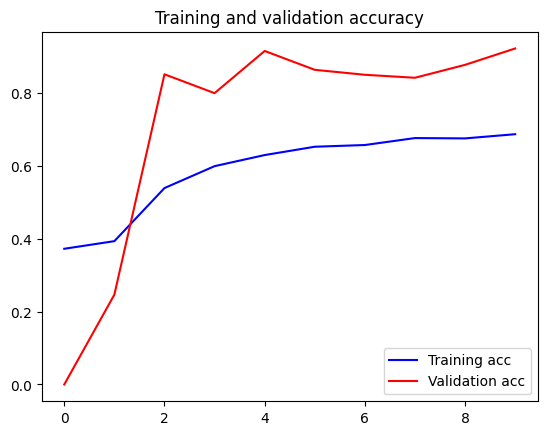

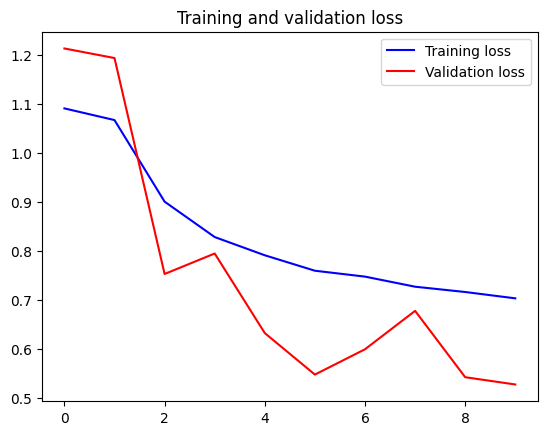

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Final Test

Melakukan testing prediksi untuk data baru yang tidak ada dalam dataset

In [ ]:
labels = ['LOW', 'MEDIUM', 'HIGH']

In [ ]:
new_service = ["jasa pembuatan API marketplace"]
seq = text_vectorizer(new_service)
print(seq)
pred = model.predict(seq)
print(pd.DataFrame(pred[0], index=labels, columns=['Probability']))
print('Final label :', labels[np.argmax(pred)])

tf.Tensor(
[[  4   1  28 107   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 30), dtype=int64)
1/1 [==============================] - 0s 483ms/step
        Probability
LOW        0.228604
MEDIUM     0.583198
HIGH       0.188198
Final label : MEDIUM


Melihat evaluasi akhir berupa ***confusion metrics*** dan ***classification report***

In [ ]:
y_true = test_data.Label.tolist()
preds = model.predict(X_test)

21/21 [==============================] - 1s 33ms/step


In [ ]:
y_pred = []
for label in preds:
  y_pred.append(labels[np.argmax(label)])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

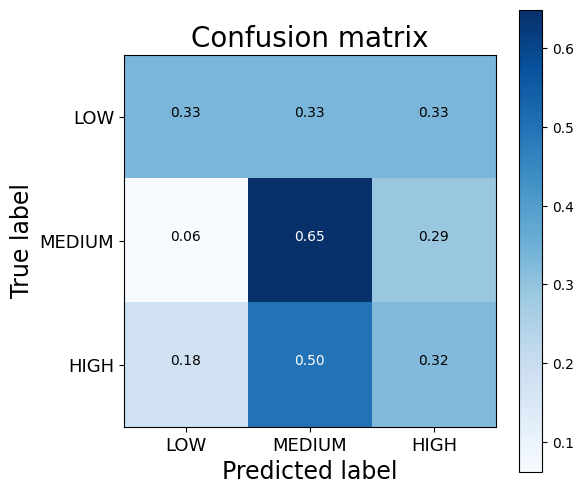

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.Label.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        HIGH       0.02      0.33      0.04         3
         LOW       0.96      0.65      0.78       613
      MEDIUM       0.05      0.32      0.08        28

    accuracy                           0.63       644
   macro avg       0.34      0.43      0.30       644
weighted avg       0.92      0.63      0.74       644

